# Анализ прибыльности двух тарифов
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. <br>
Необходимо проанализировать поведение клиентов и сделать вывод — какой тариф лучше, а так же проанализировать гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## Изучение данных 

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st

In [2]:
# константы проекта
date_format = '%Y-%m-%d'

In [3]:
# чтение файлов
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')
# информация о таблицах
calls.info()
display(calls.head())
internet.info()
display(internet.head())
messages.info()
display(messages.head())
tariffs.info()
display(tariffs)
users.info()
display(users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Предварительный анализ данных не выявил пропусков и null'овых значений в таблицах. Типы данных вполне корректны, за исключением столбцов с датой, которые следует перевести в тип datetime.

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = date_format)
internet['session_date'] = pd.to_datetime(internet['session_date'], format = date_format)
messages['message_date'] = pd.to_datetime(messages['message_date'], format = date_format)
users['churn_date'] = pd.to_datetime(users['churn_date'], format = date_format)


In [5]:
# проверим на дубликаты
calls.duplicated().sum()
messages.duplicated().sum()
internet.duplicated().sum()

0

Анализ на дубликаты так же не выявил никаких аномалий и повторений.

## Предобработка данных и составление новых таблиц

По условиям тарификации длительность звонков всегда округляется в большую сторону. В таблице calls необходимо создать дополнительный столбец с продолжительностью звонков для тарификации - округлением  до целого в большую сторону.

In [6]:
calls['tarif_duration'] = np.ceil(calls['duration'])
calls['tarif_duration'] = calls['tarif_duration'].astype('int')
display(calls.head())

,id,call_date,duration,user_id,tarif_duration
0,1000_0,2018-07-25,0.00,1000,0
1,1000_1,2018-08-17,0.00,1000,0
2,1000_2,2018-06-11,2.85,1000,3
3,1000_3,2018-09-21,13.80,1000,14
4,1000_4,2018-12-15,5.18,1000,6


Поскольку мы будем собирать статистику по месяцам, нам необходимо в каждой таблице извлечь номер месяца.

In [7]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
users['reg_month'] = pd.DatetimeIndex(users['reg_date']).month
users['exit_month'] = pd.DatetimeIndex(users['churn_date']).month
users = users.fillna(0)
users['tariff'].value_counts()


smart    351
ultra    149
Name: tariff, dtype: int64

In [8]:
# сделаем сводные таблицы по клиентам отдельно - по звонкам, сессиям и сообщениям, и посчитаем количество тарифицируемых данных помесячно
# по звонкам
calls_pivot = pd.pivot_table(calls, index = 'user_id', columns ='month', values = 'tarif_duration', aggfunc = 'sum') # сводная таблица с колонками - месяцами
calls_pivot = calls_pivot.fillna(0)   # заполнение пропусков в тех месяцах, где тариф не использовался
calls_pivot = calls_pivot.astype(int) # приведение к целочисленному типу
display(calls_pivot.head())
#посчитаем среднемесячную длину звонков
def average(line):
    result = 0
    sum_m =0
    len_m = 0
    for column in range(1, 13):
        if line[column] != 0:
            len_m +=1
            sum_m += line[column]
    try:
        result = sum_m/len_m
    except:
        0
    return result       

calls_pivot['av_minutes'] = calls_pivot.apply(average, axis =1)

calls_pivot.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0,0,0,0,159,172,340,408,466,350,338,333
1001,0,0,0,0,0,0,0,0,0,0,430,414
1002,0,0,0,0,0,117,214,289,206,212,243,236
1003,0,0,0,0,0,0,0,380,961,855,824,802
1004,0,0,0,0,35,171,135,137,117,145,117,130


month,1,2,3,4,5,6,7,8,9,10,11,12,av_minutes
user_id,,,,,,,,,,,,,
1000,0,0,0,0,159,172,340,408,466,350,338,333,320.750000
1001,0,0,0,0,0,0,0,0,0,0,430,414,422.000000
1002,0,0,0,0,0,117,214,289,206,212,243,236,216.714286
1003,0,0,0,0,0,0,0,380,961,855,824,802,764.400000
1004,0,0,0,0,35,171,135,137,117,145,117,130,123.375000


In [9]:
# по интернет-сессиям
internet_pivot = pd.pivot_table(internet, index = 'user_id', columns = 'month', values = 'mb_used', aggfunc = 'sum')
internet_pivot = internet_pivot.fillna(0)
internet_pivot['av_traffic'] = internet_pivot.apply(average, axis =1)
display(internet_pivot.head())

month,1,2,3,4,5,6,7,8,9,10,11,12,av_traffic
user_id,,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61,13424.038750
1001,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,18429.34,14036.66,16233.000000
1002,0.0,0.0,0.0,0.0,0.00,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73,16576.645714
1003,0.0,0.0,0.0,0.0,0.00,0.00,0.00,8565.21,12468.87,14768.14,11356.89,10121.53,11456.128000
1004,0.0,0.0,0.0,0.0,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04,18629.935000


In [10]:
# по сообщениям
messages_pivot = pd.pivot_table(messages, index = 'user_id', columns ='month', values = 'id', aggfunc = 'count')
messages_pivot = messages_pivot.fillna(0)
messages_pivot = messages_pivot.astype(int)
messages_pivot['av_messages'] = messages_pivot.apply(average, axis = 1)
display(messages_pivot.head())

month,1,2,3,4,5,6,7,8,9,10,11,12,av_messages
user_id,,,,,,,,,,,,,
1000,0,0,0,0,22,60,75,81,57,73,58,70,62.0
1002,0,0,0,0,0,4,11,13,4,10,16,12,10.0
1003,0,0,0,0,0,0,0,37,91,83,94,75,76.0
1004,0,0,0,0,95,134,181,151,146,165,158,162,149.0
1005,7,38,56,41,42,47,56,64,52,44,51,54,46.0


Для дальнейшего исследования нам необходимо рассчитать по каждому клиенту, сколько выручки он принес компании в каждом месяце. Это можно сделать несколькими способами по следующей формуле: <br>
**абонентская плата + цена за минуту разговора х кол-во минут сверх пакета + цена за Гб х кол-во Гб сверх пакета + цена за sms х кол-во sms сверх пакета**. <br>
Расчет делается помесячно, принимая во внимание, что: <br>
- расчеты ведутся по календарным месяцам, а не отсчитывая от даты регистрации контракта,
- в месяц подключения тарифа абонентская плата списывается сразу,
- в месяц, когда контракт заканчивается, абонентская плата не списывается. <br>
Эти гипотезы принимаются как данность, и, безусловно, являются некоторым упрощением и создают погрешность в вычислениях. Но для нашего анализа такая неточность вполне допустима и не влияет на финальные результаты и выводы.

In [11]:
# для расчета выручки и прибыли по каждому клиенту необходимо создать отдельные таблицы с доходами по каждому виду деятельности
# по звонкам
calls_revenue = calls.pivot_table(index = 'user_id', columns ='month', values = 'tarif_duration', aggfunc = 'sum') #соберем заново статистику звонков по каждому юзеру
calls_revenue = calls_revenue.fillna(0)
calls_revenue = calls_revenue.astype('int') # приведем к целочисленному типу
calls_revenue = pd.merge(calls_revenue, users[['user_id', 'tariff', 'exit_month']], left_on = 'user_id', right_on = 'user_id') # добавим информацию по тарифу каждого юзера и (ниже) детали по нему
calls_revenue = pd.merge(calls_revenue, tariffs[['tariff_name', 'minutes_included', 'rub_monthly_fee', 'rub_per_minute']], left_on = 'tariff', right_on = 'tariff_name')
calls_revenue.reset_index(drop = True, inplace = True)
for column in range(1,13):   # в столбце с порядковым номером месяца вычислим товарооборот от звонков по юзеру (не включая плату за тариф)
    calls_revenue[column] = (calls_revenue[column] - calls_revenue['minutes_included'])*calls_revenue['rub_per_minute']
    calls_revenue[column] = calls_revenue[column].apply(lambda x: x if x>0 else 0)
calls_revenue.set_index(calls_revenue['user_id'], inplace = True)
display(calls_revenue.head())

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,exit_month,tariff_name,minutes_included,rub_monthly_fee,rub_per_minute
user_id,,,,,,,,,,,,,,,,,,,
1000,1000,0,0,0,0,0,0,0,0,0,0,0,0,ultra,0.0,ultra,3000,1950,1
1003,1003,0,0,0,0,0,0,0,0,0,0,0,0,ultra,0.0,ultra,3000,1950,1
1004,1004,0,0,0,0,0,0,0,0,0,0,0,0,ultra,0.0,ultra,3000,1950,1
1013,1013,0,0,0,0,0,0,0,0,0,0,0,0,ultra,0.0,ultra,3000,1950,1
1016,1016,0,0,0,0,0,0,0,0,0,0,0,0,ultra,0.0,ultra,3000,1950,1


In [12]:
# по потреблению трафика
internet_revenue= pd.merge(internet_pivot, users[['user_id', 'tariff', 'exit_month']], left_index = True, right_on = 'user_id') # добавим информацию по тарифу каждого юзера и (ниже) детали по нему
internet_revenue = pd.merge(internet_revenue, tariffs[['tariff_name', 'mb_per_month_included', 'rub_per_gb', 'rub_monthly_fee']], left_on = 'tariff', right_on = 'tariff_name').sort_values(by = 'user_id')
internet_revenue = internet_revenue.reset_index(drop = True)

for column in range(1,13):   # в столбце с порядковым номером месяца вычислим товарооборот по юзеру (не включая плату за тариф)
    internet_revenue[column] = np.ceil((internet_revenue[column] - internet_revenue['mb_per_month_included'])/1024)*internet_revenue['rub_per_gb']
    internet_revenue[column] = internet_revenue[column].apply(lambda x: x if x>0 else 0)
internet_revenue.set_index(internet_revenue['user_id'], inplace = True)
internet_revenue.head()


,1,2,3,4,5,6,7,8,9,10,11,12,av_traffic,user_id,tariff,exit_month,tariff_name,mb_per_month_included,rub_per_gb,rub_monthly_fee
user_id,,,,,,,,,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13424.038750,1000,ultra,0.0,ultra,30720,150,1950
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,0.0,16233.000000,1001,smart,0.0,smart,15360,200,550
1002,0.0,0.0,0.0,0.0,0.0,0.0,600.0,1000.0,400.0,0.0,800.0,600.0,16576.645714,1002,smart,0.0,smart,15360,200,550
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11456.128000,1003,ultra,0.0,ultra,30720,150,1950
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18629.935000,1004,ultra,0.0,ultra,30720,150,1950


In [13]:
# по сообщениям
messages_revenue= pd.merge(messages_pivot, users[['user_id', 'tariff', 'exit_month']], left_index = True, right_on = 'user_id') # добавим информацию по тарифу каждого юзера и (ниже) детали по нему
messages_revenue = pd.merge(messages_revenue, tariffs[['tariff_name', 'messages_included', 'rub_per_message', 'rub_monthly_fee']], left_on = 'tariff', right_on = 'tariff_name').sort_values(by = 'user_id')
messages_revenue = messages_revenue.reset_index(drop = True)

for column in range(1,13):   # в колонке с порядковым номером месяца вычислим товарооборот по юзеру (не включая плату за тариф)
    messages_revenue[column] = (messages_revenue[column] - messages_revenue['messages_included'])*messages_revenue['rub_per_message']
    messages_revenue[column] = messages_revenue[column].apply(lambda x: x if x>0 else 0)
messages_revenue.set_index(messages_revenue['user_id'], inplace = True)


In [14]:
# заполним таблицу данными по клиентам
total_revenue = users[['user_id', 'tariff', 'reg_month', 'exit_month']]
for i in range (1, 13):
    total_revenue[i] = 0

total_revenue.set_index(total_revenue['user_id'], inplace = True)

for index in total_revenue.index:
    if (total_revenue.loc[index, 'exit_month']!=0) and (int(total_revenue.loc[index, 'exit_month']) != int(total_revenue.loc[index, 'reg_month'])): #если клиент перестал пользоваться услаги сети, то последнее снятие денег - в предыдущий месяц
        churn = int(total_revenue.loc[index, 'exit_month'])
    else:
        churn = 13
    for column in range(int(total_revenue.loc[index, 'reg_month']), churn): #подсчитаем товарооборот как сумму по всем трем статьям: интернет, звонки, сообщения. Если клиента нет в одном из списков, будет ошибка, которую отработает при помощи try - except
        try:
            total_revenue.loc[index, column] = calls_revenue.loc[index, column] + messages_revenue.loc[index, column] + internet_revenue.loc[index, column]+ calls_revenue.loc[index, 'rub_monthly_fee']
        except:
            try:
                total_revenue.loc[index, column] = calls_revenue.loc[index, column] + internet_revenue.loc[index, column]+ calls_revenue.loc[index, 'rub_monthly_fee']
            except:
                try:
                    total_revenue.loc[index, column] = internet_revenue.loc[index, column] + internet_revenue.loc[index, 'rub_monthly_fee']
                except: 
                    try:
                        total_revenue.loc[index, column] = calls_revenue.loc[index, column] + calls_revenue.loc[index, 'rub_monthly_fee']  
                    except:
                        try:
                            total_revenue.loc[index, column] = messages_revenue.loc[index, column] + messages_revenue.loc[index, 'rub_monthly_fee'] 
                        except:
                            0
display(total_revenue.head(10))
total_revenue.info()


/tmp/ipykernel_224/982274075.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_revenue[i] = 0


,user_id,tariff,reg_month,exit_month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,,,,,
1000,1000,ultra,5,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1001,1001,smart,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1150.0,550.0
1002,1002,smart,6,0.0,0.0,0.0,0.0,0.0,0.0,550.0,1150.0,1550.0,950.0,550.0,1350.0,1150.0
1003,1003,ultra,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0
1004,1004,ultra,5,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1005,1005,smart,1,0.0,550.0,550.0,886.0,1186.0,835.0,886.0,775.0,949.0,556.0,1219.0,694.0,838.0
1006,1006,smart,2,0.0,0.0,550.0,950.0,550.0,550.0,550.0,1550.0,1350.0,750.0,1550.0,550.0,1350.0
1007,1007,smart,4,0.0,0.0,0.0,0.0,550.0,1150.0,685.0,981.0,1750.0,1015.0,550.0,990.0,550.0
1008,1008,smart,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,568.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     500 non-null    int64  
 1   tariff      500 non-null    object 
 2   reg_month   500 non-null    int64  
 3   exit_month  500 non-null    float64
 4   1           500 non-null    float64
 5   2           500 non-null    float64
 6   3           500 non-null    float64
 7   4           500 non-null    float64
 8   5           500 non-null    float64
 9   6           500 non-null    float64
 10  7           500 non-null    float64
 11  8           500 non-null    float64
 12  9           500 non-null    float64
 13  10          500 non-null    float64
 14  11          500 non-null    float64
 15  12          500 non-null    float64
dtypes: float64(13), int64(2), object(1)
memory usage: 82.6+ KB


In [15]:
# добавим среднемесячную выручку по каждому клиенту
# определим функцию расчета среднего месячного платежа, применимую к каждой строке
def av_month(line):
    reg = int(line['reg_month'])
    if line['exit_month'] != 0:
        end = int(line['exit_month'])
    else:
        end = 12
        
    sum =0
    for column in range(reg, (end+1)):
        sum = sum + line[column]
    average = sum / (end - reg+1)    
    return average

total_revenue['av_month_revenue'] = total_revenue.apply(av_month, axis = 1)
total_revenue.head(10)


,user_id,tariff,reg_month,exit_month,1,2,3,4,5,6,7,8,9,10,11,12,av_month_revenue
user_id,,,,,,,,,,,,,,,,,
1000,1000,ultra,5,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.000000
1001,1001,smart,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1150.0,550.0,850.000000
1002,1002,smart,6,0.0,0.0,0.0,0.0,0.0,0.0,550.0,1150.0,1550.0,950.0,550.0,1350.0,1150.0,1035.714286
1003,1003,ultra,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.000000
1004,1004,ultra,5,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.000000
1005,1005,smart,1,0.0,550.0,550.0,886.0,1186.0,835.0,886.0,775.0,949.0,556.0,1219.0,694.0,838.0,827.000000
1006,1006,smart,2,0.0,0.0,550.0,950.0,550.0,550.0,550.0,1550.0,1350.0,750.0,1550.0,550.0,1350.0,931.818182
1007,1007,smart,4,0.0,0.0,0.0,0.0,550.0,1150.0,685.0,981.0,1750.0,1015.0,550.0,990.0,550.0,913.444444
1008,1008,smart,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,568.0,568.000000


Мы свели воедино доходы по каждому клиенту и посчитали помесячные и среднемесячные значения. Теперь данные готовы для анализа.

## Анализ поведения клиентов оператора сотовой связи

Для того, чтобы лучше понимать потребности клиентов сотового оператора, необходимо посмотреть на осуществленные звонки, потребленный интернет-трафик и отправленные сообщения по каждому тарифу в отдельности. После можно будет сравнить эти данные между собой.

In [16]:
# соберем таблицы по тарифам
# тариф smart
tariff_smart = total_revenue[['user_id', 'av_month_revenue', 'tariff']]
tariff_smart = tariff_smart.query('tariff == "smart"')
tariff_smart = pd.merge(tariff_smart, calls_pivot['av_minutes'], left_index = True, right_index = True)
tariff_smart = pd.merge(tariff_smart, internet_pivot['av_traffic'], left_index = True, right_index = True)
tariff_smart = pd.merge(tariff_smart, messages_pivot['av_messages'], left_index = True, right_index = True)
tariff_smart.info()
tariff_smart.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 1002 to 1499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           301 non-null    int64  
 1   av_month_revenue  301 non-null    float64
 2   tariff            301 non-null    object 
 3   av_minutes        301 non-null    float64
 4   av_traffic        301 non-null    float64
 5   av_messages       301 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 16.5+ KB


,user_id,av_month_revenue,tariff,av_minutes,av_traffic,av_messages
user_id,,,,,,
1002,1002,1035.714286,smart,216.714286,16576.645714,10.0
1005,1005,827.000000,smart,550.416667,8307.275833,46.0
1007,1007,913.444444,smart,486.555556,14625.074444,25.0
1008,1008,568.000000,smart,339.000000,13217.140000,56.0
1009,1009,1310.000000,smart,218.900000,17741.121000,11.0


In [17]:
# объединим данные из всех таблиц и потом отфильтруем таблицы по тарифам в отдельные
tariffs_all = total_revenue[['user_id', 'av_month_revenue', 'tariff']]
tariffs_all  = pd.merge(tariffs_all, calls_pivot['av_minutes'], how ='outer', left_index = True, right_index = True)
tariffs_all  = pd.merge(tariffs_all, internet_pivot['av_traffic'], how ='outer', left_index = True, right_index = True)
tariffs_all  = pd.merge(tariffs_all, messages_pivot['av_messages'], how ='outer', left_index = True, right_index = True)
tariff_ultra = tariffs_all.query('tariff == "ultra"') # тариф ultra
tariff_smart = tariffs_all.query('tariff == "smart"') # тариф smart
tariff_ultra.info()
tariff_smart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 1000 to 1495
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           149 non-null    int64  
 1   av_month_revenue  149 non-null    float64
 2   tariff            149 non-null    object 
 3   av_minutes        143 non-null    float64
 4   av_traffic        147 non-null    float64
 5   av_messages       124 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 8.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 1001 to 1499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           351 non-null    int64  
 1   av_month_revenue  351 non-null    float64
 2   tariff            351 non-null    object 
 3   av_minutes        349 non-null    float64
 4   av_traffic        350 non-null    float64
 5   av_messages 

In [18]:
# опишем поведение клиентов тарифа smart
tariff_smart.describe()

,user_id,av_month_revenue,av_minutes,av_traffic,av_messages
count,351.000000,351.000000,349.000000,350.000000,302.000000
mean,1244.133903,1310.049998,420.848019,16216.183827,37.575606
std,144.985228,618.392166,143.451303,3622.659828,24.849738
min,1001.000000,0.000000,15.111111,5384.218182,1.000000
25%,1120.000000,863.809524,317.545455,13947.652500,19.000000
50%,1236.000000,1173.000000,425.250000,16267.380000,33.000000
75%,1371.500000,1667.166667,520.400000,18633.567083,54.000000
max,1499.000000,4333.333333,891.500000,27286.960000,118.000000


In [19]:
#построим таблицу : среднее и дисперсия
mean = np.mean(tariff_smart[['av_minutes', 'av_traffic', 'av_messages']])
median=(tariff_smart[['av_minutes', 'av_traffic', 'av_messages']]).median()
std = np.std(tariff_smart[['av_minutes', 'av_traffic', 'av_messages']])
dvar = round(np.var(tariff_smart[['av_minutes', 'av_traffic', 'av_messages']]), 2)

table = pd.DataFrame(data=[mean, median, std, dvar], columns = ['av_minutes', 'av_traffic', 'av_messages'])
table.set_index([['Среднее', 'Медиана', 'Станд.отклонение', 'Дисперсия']], inplace = True)
table.rename(columns = {'av_minutes':'Израсходованные минуты', 'av_traffic':"Израсходованные Мб", 'av_messages':"Израсходованные sms"})

,Израсходованные минуты,Израсходованные Мб,Израсходованные sms
Среднее,420.848019,1.621618e+04,37.575606
Медиана,425.250000,1.626738e+04,33.000000
Станд.отклонение,143.245638,3.617481e+03,24.808562
Дисперсия,20519.310000,1.308617e+07,615.460000


**Выводы и предложения**. <br>
Анализ по клиентам тарифа *Smart* дал нам возможность сделать следующие выводы:<br>
1) данные хорошего качества, большого количества выбросов и аномалий не наблюдается. Данные однородны. <br>
2) в целом потребление минут, интернет-трафика и сообщений распределено нормально, разброс данных небольшой. Распределение потребленных сообщений немного смещено вправо.<br>
3) пик значений в категории "звонки" приходится на интервал от 400 до 500 минут (среднее - 420, медиана - 425), при лимите предоплаченного пакета в 500 минут. Это означает, что большинство клиентов используют примерно столько минут, сколько включено пакет - значит, тариф хорошо соответствует их потребностям.<br>
4) те же самые выводы можно сделать о потреблении интернет-трафика с пиковым значением в 16,2 тыс. Мбайт (при лимите пакета 15360 Мб). Очевидно, клиентам совсем немного не хватает пакета и они регулярно доплачивают за небольшое количество гигабайт в дополнение к стандартному тарифу.<br>
5) В статистике количества использованных sms сообщений довольно большой разброс (дисперсия) - 615 при средней 38 сообщений. Это говорит о неоднородности данных. Однозначных выводов о том, как клиенты используют свой пакет сообщений (50 шт.), мы не можем сделать. Очевидно,  некоторые клиенты не так активно прибегают к sms сообщениям, как другие. 
<br> <br>
В целом, можно сделать вывод, что тариф *Smart* хорошо соответствует потребностям клиентов, которые его используют.
<br> <br>
В нашей выборке количество клиентов с тарифом *Smart* преобладает - 351 против 149 на тарифе *Ultra*. Мы не знаем, является ли это соотношение репрезентующим генеральную совокупность, или просто совпадением, или выборка была сделана намеренно именно в такой пропорции. Но если предположить, что такая пропорция сохраняется и в генеральной совокупности, то это может объясняться *невысокой ценой* и *оптимизированным размеров предоплаченных пакетов услуг*.  

In [20]:
# опишем поведение клиентов тарифа ultra
tariff_ultra.describe()

,user_id,av_month_revenue,av_minutes,av_traffic,av_messages
count,149.000000,149.000000,143.000000,147.000000,124.000000
mean,1262.140940,2031.636596,546.998401,19744.083245,64.555802
std,142.976516,375.006672,268.089662,8169.947017,43.390612
min,1000.000000,0.000000,16.500000,2301.760000,3.000000
25%,1143.000000,1950.000000,342.883333,14806.842000,28.000000
50%,1276.000000,1950.000000,525.500000,18986.568000,57.800000
75%,1379.000000,1975.000000,750.000000,25964.860000,89.000000
max,1495.000000,3225.000000,1179.363636,38463.570000,192.000000


In [21]:
#построим таблицу : среднее и дисперсия
median=(tariff_ultra[['av_minutes', 'av_traffic', 'av_messages']]).median()
std = np.std(tariff_ultra[['av_minutes', 'av_traffic', 'av_messages']])
dvar = round(np.var(tariff_ultra[['av_minutes', 'av_traffic', 'av_messages']]), 2)

table = pd.DataFrame(data=[mean, median, std, dvar], columns = ['av_minutes', 'av_traffic', 'av_messages'])
table.set_index([['Среднее', 'Медиана', 'Станд.отклонение', 'Дисперсия']], inplace = True)
table.rename(columns = {'av_minutes':'Израсходованные минуты', 'av_traffic':"Израсходованные Мб", 'av_messages':"Израсходованные sms"})

,Израсходованные минуты,Израсходованные Мб,Израсходованные sms
Среднее,420.848019,1.621618e+04,37.575606
Медиана,525.500000,1.898657e+04,57.800000
Станд.отклонение,267.150642,8.142111e+03,43.215296
Дисперсия,71369.470000,6.629397e+07,1867.560000


**Выводы и предложения**. <br>
Анализ по клиентам тарифа *Ultra* дал нам возможность сделать следующие выводы:<br>
1) данные хорошего качества, большого количества выбросов и аномалий не наблюдается. Данные однородны.<br>
2) в целом потребление минут, интернет-трафика и сообщений распределено нормально, разброс данных небольшой. Распределение потребленных сообщений значительно смещено вправо.<br><br>
3) пик значений в категории "звонки" приходится на интервал от 500 до 600 минут (среднее - 546, медиана - 525), при лимите предоплаченного пакета в 3000 минут. Это означает, что большинство клиентов не используют до конца свой пакет предоплаченных минут. Более того, в данной выборке абсолютное большинство не использует даже половины пакета минут (максимальное значение среди усредненных по клиенту - 1179. <br>
Это говорит о неэффективности использования этого тарифа клиентами, как минимум в плане звонков. Для клиентов было бы более выгодным иметь пакет в 1000 минут по более низкой цене. <br>
4) Исходя из данных о потреблении интернет-трафика с пиковым значением в ~19 Гб (при лимите пакета 30 Гб) можно сделать вывод, что большинство клиентов (не менее 75%, третий квартиль) не используют до конца свой пакет интренет-трафика. Доплаты за трафик крайне редки, хотя не исключены. <br>
5) В статистике количества использованных sms сообщений довольно большой разброс (дисперсия) - 615(примечательно, что она равна дисперсии по тарифу Smart, хотя средние различаются). Это говорит о неоднородности данных. В любом случае, совершенно очевидно, что клиенты не используют весь доступный им пакет в 1000 сообщений.
<br> <br>
В целом, можно сделать вывод, что тариф *Ultra* менее сбалансирован по  сравнению с тарифом Smart и значительно хуже соответствует потребностям клиентов, которые его используют.<br>


Сравним и визуализируем два тарифа и данные о них.

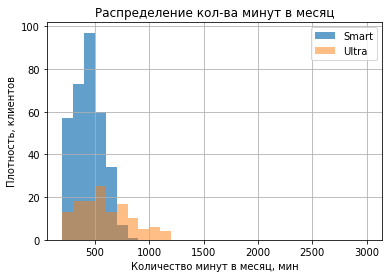

In [22]:
tariff_smart['av_minutes'].plot(kind = 'hist', 
                                bins = [200, 300, 400, 500, 600, 700, 800, 900, 1000,1100, 1200, 1300, 1400, 1500, 3000], 
                                title ='Распределение кол-ва минут в месяц', 
                                alpha = 0.7, 
                                grid = True)

tariff_ultra['av_minutes'].plot(kind = 'hist', 
                                bins = [200, 300, 400, 500, 600, 700, 800, 900, 1000,1100, 1200, 1300, 1400, 1500, 3000], 
                                alpha =0.5,
                                grid = True)
plt.xlabel('Количество минут в месяц, мин');
plt.ylabel('Плотность, клиентов')
plt.xlabel('Количество минут в месяц, мин');
plt.legend(['Smart', 'Ultra'])
plt.show()

На графике мы видим, что пики приходятся на примерно один и тот же промежуток с 400 до 600 минут. 

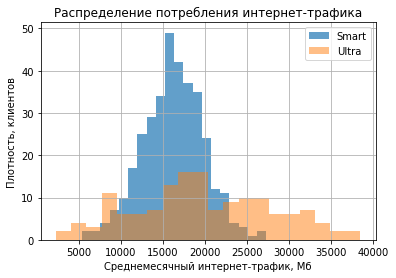

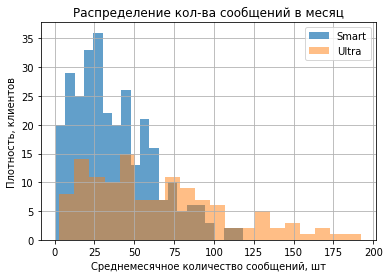

In [23]:
tariff_smart['av_traffic'].plot(kind = 'hist',
                                bins = 20, 
                                title ='Распределение потребления интернет-трафика',
                                alpha = 0.7,
                                grid = True)
plt.ylabel('Плотность, клиентов')
plt.xlabel('Среднемесячный интернет-трафик, Мб');
tariff_ultra['av_traffic'].plot(kind = 'hist', 
                                bins = 20, 
                                title ='Распределение потребления интернет-трафика', 
                                alpha = 0.5,
                                grid = True)
plt.ylabel('Плотность, клиентов')
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Среднемесячный интернет-трафик, Мб');
plt.show()

tariff_smart['av_messages'].plot(kind = 'hist', 
                                 bins = 20, 
                                 title ='Распределение кол-ва сообщении в месяц', 
                                 alpha = 0.7,
                                 grid = True)
plt.ylabel('Плотность, клиентов')
plt.xlabel('Среднемесячное количество сообщений, шт');
tariff_ultra['av_messages'].plot(kind = 'hist', 
                                 bins = 20, 
                                 title ='Распределение кол-ва сообщений в месяц', 
                                 alpha = 0.5,
                                 grid = True)
plt.ylabel('Плотность, клиентов')
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Среднемесячное количество сообщений, шт');

График распределения интернет-трафика тарифа Ultra гораздо более пологий и имеет более широкие границы, чем график такрифа Smart. Это говорит о более однородном характере использования интернета среди клиентов Smart, чем клиентов Ultra. <br>
Графики распределения сообщений более менее похожи по форме и подтверждают ранее высказанное предположение о том, что использование сообщений различается в зависимости от разных категорий клиентов.

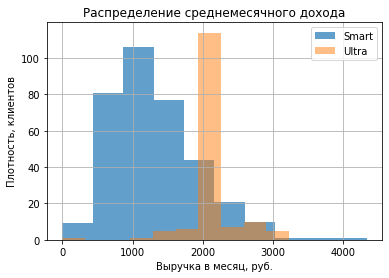

In [24]:
tariff_smart['av_month_revenue'].plot(kind = 'hist', 
                                title ='Распределение среднемесячного дохода', 
                                alpha = 0.7, 
                                grid = True)

tariff_ultra['av_month_revenue'].plot(kind = 'hist',
                                alpha =0.5,
                                grid = True)
plt.xlabel('Выручка в месяц, руб.');
plt.ylabel('Плотность, клиентов')
plt.xlabel('Выручка в месяц, руб.');
plt.legend(['Smart', 'Ultra'])
plt.show()

По графику видно, что в доходы от тарифа Smart и тарифа Ultra распределены по-разному, хотя оба подчиняются закону нормального распределения. Для тарифа Ultra характерен высокий пик, приходящийся на значение в 2000 рублей (медиана 1950р., это соответствует значению месячной абонентской платы). <br>
В тарифе Smart значения распределны более однородно и в большей массе они превышают месячную абонентскую плату. Однако большинство клиентов приносят значительно меньше денег, чем большинство клиентов Ultra. Поэтому легко сделать вывод о **большей финансовой привлекательности тарифа Ultra для компании-оператора.**

In [25]:
calls_pivot = pd.merge(calls_pivot, users, left_index = True, right_on = 'user_id')
month_names = {1: "Январь", 2:"Февраль", 3:"Март", 4:"Апрель", 5:"Май", 6:"Июнь", 7:"Июль", 8:"Август", 9:"Сентябрь", 10:'Октябрь', 11:'Ноябрь', 12:'Декабрь'}

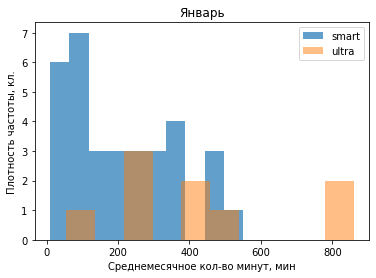

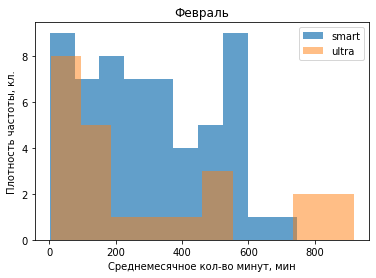

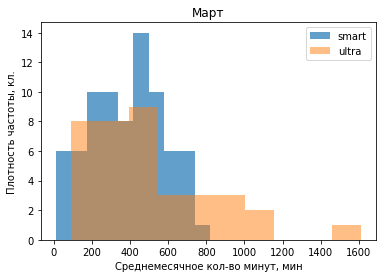

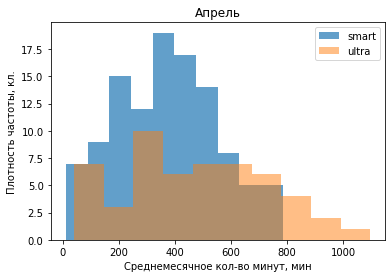

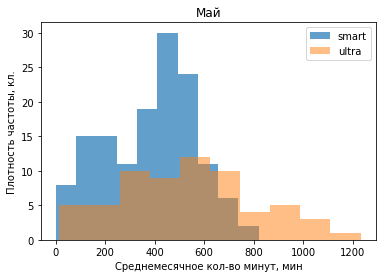

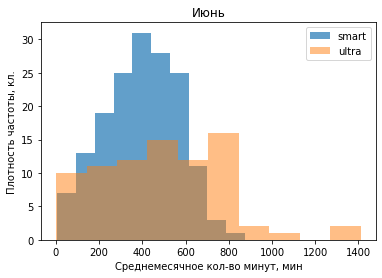

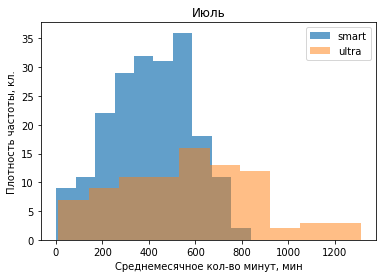

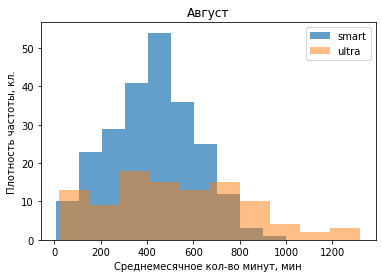

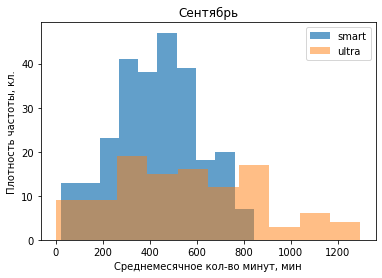

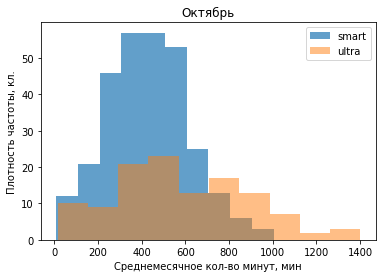

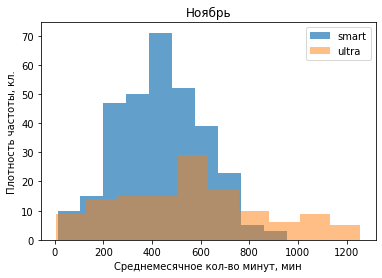

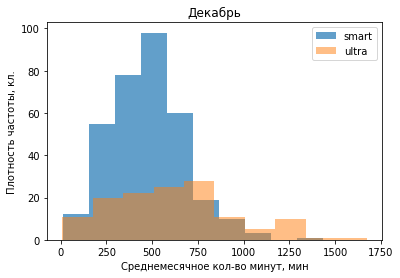

In [26]:

for i in range(1, 13):
    calls_pivot[calls_pivot[i]>0].query('tariff == "smart"')[i].plot(kind = 'hist', alpha = 0.7) # отфильтруем 0 и построим графиик по тарифу смарт
    calls_pivot[calls_pivot[i]>0].query('tariff == "ultra"')[i].plot(kind = 'hist', alpha = 0.5) # отфильтруем 0 и построим графики по тарифу ультра
    plt.xlabel('Среднемесячное кол-во минут, мин')
    plt.ylabel('Плотность частоты, кл.')
    plt.title(month_names[i])
    plt.legend(['smart', 'ultra'])
    plt.show();

    

На графиках видно две особенности распределения кол-ва потребленных минут: <br>
1) часто в один и тот же месяц график распределения частоты повторяется для Smart и Ultra, <br>
2) пиковые значения тарифа Ultra смещены вправо относительно пиковых значений Smart. <br>
В целом это подтверждает, что на тарифе Ultra тратят больше минут в месяц, чем на другом тарифе.
Можно также сделать наблюдение, что каждому месяцу характерно определенное распределение частот, которое не сильно меняется от тарифа к тарифу и видимо зависит от неких внешних факторов.

In [ ]:
internet_pivot = pd.merge(internet_pivot, users, left_index = True, right_on = 'user_id')

In [ ]:
try:
    for i in range(1, 13):
        internet_pivot[internet_pivot[i]>0].query('tariff == "smart"')[i].plot(kind = 'hist', alpha = 0.7) # отфильтруем 0 и построим графики по тарифу смарт
        internet_pivot[internet_pivot[i]>0].query('tariff == "ultra"')[i].plot(kind = 'hist', alpha = 0.5) # отфильтруем 0 и построим графики по тарифу ультра
        plt.xlabel('Среднемесячное кол-во трафика, Гб')
        plt.ylabel('Плотность частоты, кл.')
        plt.title(month_names[i])
        plt.legend(['smart', 'ultra'])
        plt.show();
except:
    pass

По графикам интернет-трафика вывод противоположный  - графики распределения для двух тарифов существенно отличаются - у тарифа Ultra он пологий, с неявным пиком практически во все месяцы, а у тарифа Smart в каждом месяце имеется явный пик, которой приходится на 15-20 Гб в месяц. <br> Это означает что большинство клиентов тарифа Smart, скорее всего, стараются не превышать лимит включенного в пакет трафика, или несильно превышать. Клиенты тарифа Ultra не так внимательны к лимитам и потребляют столько трафика, сколько им нужно (больше или меньше лимита в зависимоти от клиента).

In [ ]:
messages_pivot = pd.merge(messages_pivot, users, left_index = True, right_on = 'user_id')

In [27]:

for month in range(1, 13):
    messages_pivot[internet_pivot[month]>0].query('tariff == "smart"')[i].plot(kind = 'hist', alpha = 0.7) # отфильтруем 0 и построим графики по тарифу смарт
    messages_pivot[internet_pivot[month]>0].query('tariff == "ultra"')[i].plot(kind = 'hist', alpha = 0.5) # отфильтруем 0 и построим графики по тарифу ультра
    plt.xlabel('Среднемесячное кол-во сообщений, смс')
    plt.ylabel('Плотность частоты, кл.')
    plt.title(month_names[month])
    plt.legend(['smart', 'ultra'])
    plt.show();

/tmp/ipykernel_224/3770254282.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  messages_pivot[internet_pivot[month]>0].query('tariff == "smart"')[i].plot(kind = 'hist', alpha = 0.7) # отфильтруем 0 и построим графики по тарифу смарт


По помесячным графикам распределения сообщений можно сделать следующий вывод: <br>
1. От месяца к месяцу становится все более очевидно, что распределение смещено вправо, то есть пик приходит на 0 или минимальное количество сообщений. В данном случае это никак не связано с сезонностью, а связано с характером выборки - в нее попали только те, кто регистрировали контракт в течение 2018 года. К концу года количество регистраций значительно выше, чем к началу, поэтому статистики больше и она более репрезентативна. (Этот последний комментарий так же применим к графика по звонкам и интернет-трафику.) <br>
2. Очевидно наблюдается тот факт, что клиенты тарифа Smart не используют или почти не используют sms-сообщения, очевидный пик приходится на промежуток от 0 до 10 (и это при том, что все нулевые значения я вообще отсеяла). На тарифе Ultra сообщения более востребованы, хотя тоже не очень популярны. <br><br>
Можно выдвинуть гипотезу, что клиенты тарифа smart в среднем более молоды, чем клиенты Ultra и пользуются мессенжерами вместо sms. Косвенно это так же подтверждается ценой на тариф Ultra и отношением к потреблению интернет-трафика.

## Проверка гипотез

Нам необходимо проверить на валидность две различных гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


###  Средняя выручка от пользователей тарифов Ультра и Смарт различаются

Сформулируем нулевую гипотезу по этому вопросу: "Средняя месячная выручка от пользователей тарифа Ультра равна средней месячной выручке от пользователей тарифа Смарт" (двустороняя гипотеза).

In [ ]:
hyp0_smart = total_revenue.query('tariff == "smart"') # выделим данные по тарифу Smart
hyp0_smart = hyp0_smart.loc[:, 1:12]
datalist=[]
for line in hyp0_smart.index:  # соберем все сырые данные о помесячной выручке в один список, а затем - в единый столбец
    for column in range(1, 13):
        if hyp0_smart.loc[line, column]>0:
            datalist.append(hyp0_smart.loc[line, column])
datalist_smart = pd.Series(datalist)


In [ ]:
hyp0_ultra = total_revenue.query('tariff == "ultra"') # выделим данные по тарифу Ultra
hyp0_ultra = hyp0_ultra.loc[:, 1:12]
datalist=[]
for line in hyp0_ultra.index:  # соберем все сырые данные о помесячной выручке в один список, а затем - в единый столбец
    for column in range(1, 13):
        if hyp0_ultra.loc[line, column]>0:
            datalist.append(hyp0_ultra.loc[line, column])
datalist_ultra = pd.Series(datalist)

In [ ]:
# проведем t-тест на проверку нулевой гипотезы "средние двух генеральных совокупностей равны между собой"
alpha = 0.01
results = st.ttest_ind(datalist_ultra, datalist_smart, equal_var = False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Гипотеза не подтвердилась.')
else:
    print('Гипотеза подтвердилась.')

Основываясь на данных расчета можно сделать вывод о том, что средняя месячная выручка от клиентов тарифа Ultra не равна средней вырочки по тарифу Smart. В принципе, данные выборочной совокупности это подтверждают (см п.3), это хорошо видно на графиках. <br>
Мы смогли подтвердить валидность этого удверждения и для генеральной совокупности.

### Средняя выручка от пользователей из Москвы отличается от выручки от пользователей из других регионов

Сформулируем нулевую гипотезу по этому вопросу: "Средняя месячная выручка от пользователей в Москве равна средней месячной выручке от пользователей вне Москвы (в регионах)" (двустороняя гипотеза).

In [ ]:
total_revenue = pd.merge(total_revenue, users[['city', 'user_id']], left_index = True, right_on ='user_id') #перенесем данные о городе проживания клиентов в таблицу с доходом
hyp0_moscow = total_revenue.query('city == "Москва"') # выделим данные клиентов из Москвы
hyp0_moscow = hyp0_moscow.loc[:, 1:12]
datalist=[]
for line in hyp0_moscow.index:  # соберем все сырые данные о помесячной выручке в один список, а затем - в единый столбец
    for column in range(1, 13):
        if hyp0_moscow.loc[line, column]>0:
            datalist.append(hyp0_moscow.loc[line, column])
datalist_moscow = pd.Series(datalist)


In [ ]:
hyp0_region = total_revenue.query('city != "Москва"')
hyp0_region = hyp0_region.loc[:, 1:12]
datalist=[]
for line in hyp0_region.index:  # соберем все сырые данные о помесячной выручке в один список, а затем - в единый столбец
    for column in range(1, 13):
        if hyp0_region.loc[line, column]>0:
            datalist.append(hyp0_region.loc[line, column])
datalist_region = pd.Series(datalist)

In [ ]:
# проведем t-тест на проверку нулевой гипотезы "средние двух генеральных совокупностей равны между собой"
alpha = 0.05
results = st.ttest_ind(datalist_moscow, datalist_region, equal_var = False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Гипотеза может быть отвергнута.')
else:
    print('Гипотеза не может быть отвергнута.')

Основываясь на результатая расчетов, мы делаем вывод, что наша гипотеза о том, что средняя выручка от клиентов в Москве и клиентов в регионах примерно равны, во всяком случае, нет достаточных оснований предполагать, что это не так. <br>
Это логично, учитывая, что нет различия в тарификации для клиентов различных регионов.

# Общий вывод

Мы исследовали данные от сотового оператора о клиентах двух тарифов - Smart & Ultra. <br>
Нам удалось ответить на все основные вопросы:<br>
1. Для компании больше выручки на одного клиента в месяц приносит тариф Ultra. Однако, необходимо оценить количество клиентов на этом тарифе, его фактический приток и отток, т.к. тариф кажется не сбалансированным по цене - качеству для клиента, т.к. не отвечает его потребностям (вернее, избыточен по сравнению с ними).<br>
Исходя из помесячной динамики основных показателей, можно предложить скорректировать лимиты по sms-сообщениям на оба тарифа - потребление сообщений остается одинаково низким напротяжении всего года.<br>
2. Гипотеза о совпадении средней выручки по тарифам Ultra и Smart *не подтвердилась*, что так же характерно заметно и на выборочных данных. <br>
3. Гипотеза о совпадении средней выручки по Москве и другим городам *подтвердилась*. Рекомендуется исследовать дополнительно поведение клиентов в различных регионах для более детального анализа и предложения кастомизированных тарифов по регионам. По данной выборке сделать такой анализ не представляется возможным из-за недостаточной выборки по большинству городов.

Привет! Спасибо за комментарии и рекоммендации! Я постаралась все учесть и доделать-переделать.
Отдельное спасибо что так быстро проверил - у меня еще Сборный проект висит, надо торопиться, чтобы не угодить в академ :)